# Basic config

In [2]:
#Uploading dataset from GoogleDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#To go to your drive’s main directory
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [4]:
img_dir = '/content/gdrive/My Drive/dataset/'
print(img_dir)

/content/gdrive/My Drive/dataset/


In [5]:
cd '/content/gdrive/My Drive/dataset/'

/content/gdrive/My Drive/dataset


# Data preprocessing-Split folders

In [0]:
!pip install split-folders

In [0]:
#https://github.com/jfilter/split-folders
import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.

#==========================UNCOMMENT FOR SPLITING=============================================
split_folders.ratio(img_dir, output="output", seed=1337, ratio=(.7, .15, .15)) # default values
#=================================================================================================

# Import libraries and Prepare Data

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras import backend as K

import keras

import matplotlib.pyplot as plt
import os
import tensorflow as tf

gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [9]:
#Prepare Data
img_width, img_height = 200, 200

output_dir = img_dir + 'output/'

train_data_dir = os.path.join(output_dir, 'train')
print(train_data_dir)
validation_data_dir = os.path.join(output_dir, 'val')
test_data_dir = os.path.join(output_dir, 'test')
nb_train_samples = 1490   
nb_validation_samples = 330  
nb_test_samples = 330  
epochs = 4
batch_size = 16
numclasses = 6

/content/gdrive/My Drive/dataset/output/train


# Data augmentation

In [10]:
# dataset
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    #shear_range=0.2,
    vertical_flip=False,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')



Found 1490 images belonging to 6 classes.
Found 330 images belonging to 6 classes.
Found 330 images belonging to 6 classes.


In [0]:
print(K.image_data_format())

channels_last


# Create the base model from the pre-trained convnets

In [0]:
#Model
#if channel is first set input shape => (3, 200, 200) else (200, 200, 3)
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [12]:
base_model = None
base_model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


**Freeze Convolutional base**

In [0]:
# It is important to freeze the convolutional base before you compile and train the model. 
#Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 
#MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [0]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [16]:
print(base_model.output_shape[1:])

(7, 7, 2048)


In [17]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:])) #Flattens the input. Does not affect the batch size.
for i in range(2):
  top_model.add(Dense(4096, activation='relu')) #Apply a Dense layer to convert these features into a single prediction per image. 
  top_model.add(Dropout(0.5)) #Dropout consists in randomly setting a fraction rate of input units to 0.5 at each update during training time, which helps prevent overfitting.
top_model.add(Dense(numclasses, activation='softmax'))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
top_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              411045888 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24582     
Total params: 427,851,782
Trainable params: 427,851,782
Non-trainable params: 0
________________________________________

In [0]:
#https://keras.io/getting-started/functional-api-guide/
model = None
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

**Compile the model**

In [20]:
#model = resnet50tl(input_shape, numclasses, 'softmax')
lr = 1e-5
decay = 1e-7 #0.0
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Display model/network

In [0]:
from keras.utils.vis_utils import plot_model

#plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image

#Uncomment for visualisation

#Image(filename='model.png')

# Train Model

In [21]:
#Train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/4
93/93 [==============================] - 504s 5s/step - loss: 2.1465 - acc: 0.4300 - val_loss: 0.8545 - val_acc: 0.7125
Epoch 2/4
93/93 [==============================] - 24s 256ms/step - loss: 1.2939 - acc: 0.6397 - val_loss: 0.6668 - val_acc: 0.7930
Epoch 3/4
93/93 [==============================] - 24s 258ms/step - loss: 1.0394 - acc: 0.7063 - val_loss: 0.6989 - val_acc: 0.7930
Epoch 4/4
93/93 [==============================] - 24s 257ms/step - loss: 0.7806 - acc: 0.7749 - val_loss: 0.7783 - val_acc: 0.8248


# Performance and Evaluation

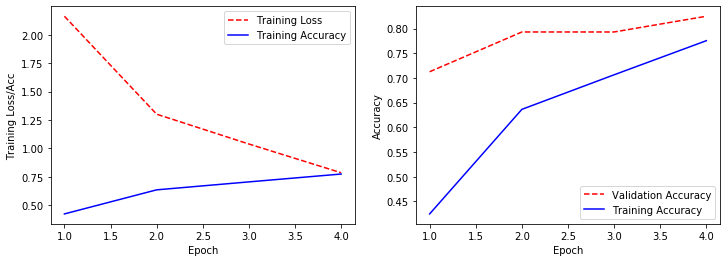

In [22]:
# Get training and test loss histories - Learning curves
training_loss = history.history['loss']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = history.history['val_acc']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [0]:
saveweight =  'celebriytag_weight_transfer.h5'
model.save_weights(saveweight)

In [0]:
model.load_weights(saveweight)

In [25]:
#Evaluate the model on test set
print(model.evaluate_generator(test_generator,steps= (nb_test_samples // batch_size), verbose = 1))

20/20 [==============================] - 95s 5s/step
[0.8317086741328239, 0.815625]


In [30]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import numpy as np
import sklearn.metrics as metrics

test_generator.reset()

Y_pred = model.predict_generator(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=-1)
sum(y_pred==classes)/10000


from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes[test_generator.index_array],y_pred)


array([[59,  0,  0,  0,  0,  2],
       [10, 32,  1,  0,  1,  0],
       [ 0,  0, 60,  0,  0,  0],
       [ 0,  0,  4, 62,  3,  0],
       [ 0,  0,  5,  7, 35,  0],
       [ 7,  1, 12,  4,  3, 22]])

In [40]:
predicted_classes = numpy.argmax(Y_pred, axis=1)

report = metrics.classification_report(classes, predicted_classes, target_names = ['aaron_diaz',  'aaron_tippin',  'aarti_chabria',  'abbey_clancy',  'abby_elliott', 'uknown'])
print('\nClassification Report: \n')
print(report)


Classification Report: 

               precision    recall  f1-score   support

   aaron_diaz       0.78      0.97      0.86        61
 aaron_tippin       0.97      0.73      0.83        44
aarti_chabria       0.73      1.00      0.85        60
 abbey_clancy       0.85      0.90      0.87        69
 abby_elliott       0.83      0.74      0.79        47
       uknown       0.92      0.45      0.60        49

     accuracy                           0.82       330
    macro avg       0.85      0.80      0.80       330
 weighted avg       0.84      0.82      0.81       330



# Fine tuning

In [0]:
#UnFreeze all the layers of base_model to train it after 5 epochs 
base_model.trainable = True

In [42]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False


Number of layers in the base model:  175


In [0]:
model2 = None
model2 = Model(inputs=base_model.input, outputs=top_model(base_model.output))

**Compile the model**

In [0]:
lr = 1e-5
decay = 1e-7 #0.0
optimizer = RMSprop(lr=lr, decay=decay)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [45]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

# Continue training the model

In [46]:
#Train no2
fine_tune_epochs = 12
total_epochs =  epochs + fine_tune_epochs

history = model2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/16
93/93 [==============================] - 29s 311ms/step - loss: 0.7216 - acc: 0.7870 - val_loss: 0.6335 - val_acc: 0.8500
Epoch 2/16
93/93 [==============================] - 24s 260ms/step - loss: 0.5336 - acc: 0.8380 - val_loss: 0.5841 - val_acc: 0.8439
Epoch 3/16
93/93 [==============================] - 24s 260ms/step - loss: 0.4796 - acc: 0.8596 - val_loss: 0.5210 - val_acc: 0.8567
Epoch 4/16
93/93 [==============================] - 24s 261ms/step - loss: 0.4394 - acc: 0.8838 - val_loss: 0.5427 - val_acc: 0.8854
Epoch 5/16
93/93 [==============================] - 24s 260ms/step - loss: 0.3286 - acc: 0.9039 - val_loss: 0.5160 - val_acc: 0.8662
Epoch 6/16
93/93 [==============================] - 24s 261ms/step - loss: 0.2905 - acc: 0.9241 - val_loss: 0.5749 - val_acc: 0.9076
Epoch 7/16
93/93 [==============================] - 24s 262ms/step - loss: 0.2674 - acc: 0.9228 - val_loss: 0.7087 - val_acc: 0.8631
Epoch 8/16
93/93 [==============================] - 24s 260ms/step - 

# Performance and Evaluation after fine tuning

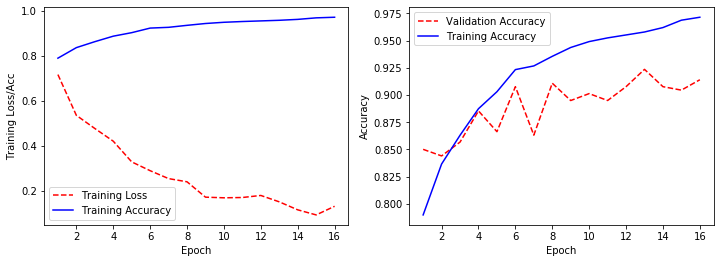

In [47]:
# Get training and test loss histories
training_loss = history.history['loss']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = history.history['val_acc']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [54]:
test_generator.reset()

Y_pred2 = model2.predict_generator(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred2 = np.argmax(Y_pred2, axis=-1)
sum(y_pred2==classes)/10000


from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes[test_generator.index_array],y_pred2)

array([[59,  0,  0,  0,  0,  2],
       [ 2, 41,  0,  0,  1,  0],
       [ 0,  0, 60,  0,  0,  0],
       [ 0,  0,  3, 61,  5,  0],
       [ 0,  0,  3,  4, 40,  0],
       [ 3,  3,  7,  1,  4, 31]])

In [55]:
predicted_classes2 = numpy.argmax(Y_pred2, axis=1)

report = metrics.classification_report(classes, predicted_classes2, target_names = ['aaron_diaz',  'aaron_tippin',  'aarti_chabria',  'abbey_clancy',  'abby_elliott', 'uknown'])
print('\nClassification Report: \n')
print(report)


Classification Report: 

               precision    recall  f1-score   support

   aaron_diaz       0.92      0.97      0.94        61
 aaron_tippin       0.93      0.93      0.93        44
aarti_chabria       0.82      1.00      0.90        60
 abbey_clancy       0.92      0.88      0.90        69
 abby_elliott       0.80      0.85      0.82        47
       uknown       0.94      0.63      0.76        49

     accuracy                           0.88       330
    macro avg       0.89      0.88      0.88       330
 weighted avg       0.89      0.88      0.88       330



In [0]:
saveweight2 =  'celebriytag_weight_transfer2.h5'
model2.save_weights(saveweight2)

In [0]:
model2.load_weights(saveweight2)

In [58]:
#Evaluate the model on test set
print(model2.evaluate_generator(test_generator,steps= (nb_test_samples // batch_size), verbose = 1))

20/20 [==============================] - 1s 58ms/step
[0.7427704913483467, 0.884375]


# Evaluation per image

In [0]:
#Evaluation
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import cv2
import requests
import os

In [0]:
labels = ['aaron_diaz',  'aaron_tippin',  'aarti_chabria',  'abbey_clancy',  'abby_elliott', 'uknown']

/content/gdrive/My Drive/dataset/output/test/aaron_tippin/


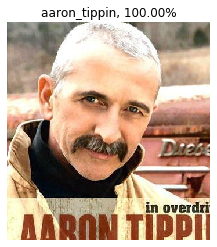

In [61]:
test_imgs = ['0311_01.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/aaron_tippin/'

print(new_validation_data_dir)

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

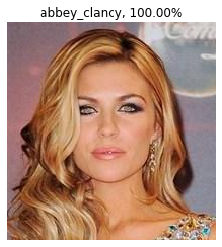

In [62]:
test_imgs = ['0058_01.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/abbey_clancy/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

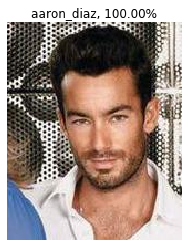

In [63]:
test_imgs = ['0081_01.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/aaron_diaz/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

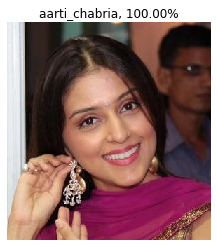

In [64]:
test_imgs = ['0205_02.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/aarti_chabria/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

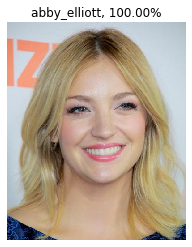

In [65]:
test_imgs = ['0037_01.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/abby_elliott/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

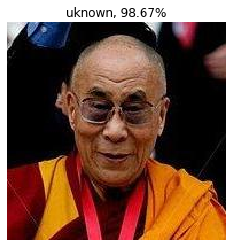

In [66]:
test_imgs = ['0003_01.jpg']

new_validation_data_dir = '/content/gdrive/My Drive/dataset/output/test/unkown/'

for test in test_imgs:
    test_img = os.path.join(new_validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)